In [443]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import requests
from shapely.geometry import Point
shp_file = gpd.read_file('datasets/geo_export_26bce2f2-c163-42a9-9329-9ca6e082c5e9.shp')
shp_file.set_crs(epsg=4326, inplace=True)
shp_file['geometry_polygon'] = shp_file['geometry']
shp_file = shp_file.loc[~(shp_file['community']== "OHARE")]
school_progress_21_22 = pd.read_csv("https://data.cityofchicago.org/resource/ngix-dc87.csv")
school_progress_22_23 = pd.read_csv("https://data.cityofchicago.org/resource/d7as-muwj.csv")
school_progress_23_24 = pd.read_csv("https://data.cityofchicago.org/resource/2dn2-x66j.csv")
crime = pd.DataFrame(requests.get("https://data.cityofchicago.org/resource/9hwr-2zxp.json").json())
crime['date'] = pd.to_datetime(crime['date'])
crime['updated_on'] = pd.to_datetime(crime['updated_on'])
data = pd.read_csv("datasets/My_CHI._My_Future._Programs.csv")


## Basic Eda
### 1. Are there any correlations between crime and availability of programs in certain districts when crime incidents happen, and more importantly, does a crime incident mean that programs are affected some considerable time after the incident? 
### 2. Is there such a thing as outlier districts that despite having high crime, they present high student attainment, high graduation rate and a great number of programs? How big of a role does crime play in access to programs and high educational attainment?


## Data preparation and cleaning

### Missing value handling

In [444]:
import geopandas as gpd
from shapely.geometry import Point
# Handle missing values
has_latlong = ~data[['Latitude', 'Longitude']].isna().all(axis=1)
has_location = ~data['Location'].isna()
location_data = data[has_latlong  | has_location]
location_data = location_data[location_data['State'] != 'KS']
# impute geographic cluster name
school_progress_21_22['date'] = pd.to_datetime('2022-09-18')
school_progress_22_23['date'] = pd.to_datetime('2023-06-06')
school_progress_23_24['date'] = pd.to_datetime('2024-10-21')
school_progress = pd.concat([school_progress_21_22, school_progress_22_23, school_progress_23_24], axis=0) # no missing zip codes, no missing latitudes and longitudes
crime.dropna(axis='rows',how='any', inplace=True) # crime only has 3 rows in which the location is missing

In [393]:
location_data = location_data.copy()
location_data.drop(['Image', 'Program URL', 'Registration URL', 'Registration Open', 
                   'Contact Phone', 'Contact Email', 'Hidden Programs', 'Featured', 
                   'Meeting Type', 'Has Free Food', 'Transport Provided', 'Participants Paid', 'Contact Name', 'Program ID', 
                   'Online Address', 'State', 'Registration Deadline', 'Scholarship Available'], 
                   axis='columns', inplace=True)

### Impute geographic cluster name

In [394]:
geometry = [Point(xy) for xy in zip(location_data['Longitude'], location_data['Latitude'])]
gdf_points = gpd.GeoDataFrame(location_data, geometry=geometry)
gdf_points.set_crs(epsg=4326, inplace=True)
points_with_labels = gpd.sjoin(gdf_points, shp_file, how='left', predicate='within')


In [395]:
points_with_labels = points_with_labels.dropna(subset=['community'])

In [396]:
points_with_labels = points_with_labels.loc[~(points_with_labels['community'] == 'OHARE')]

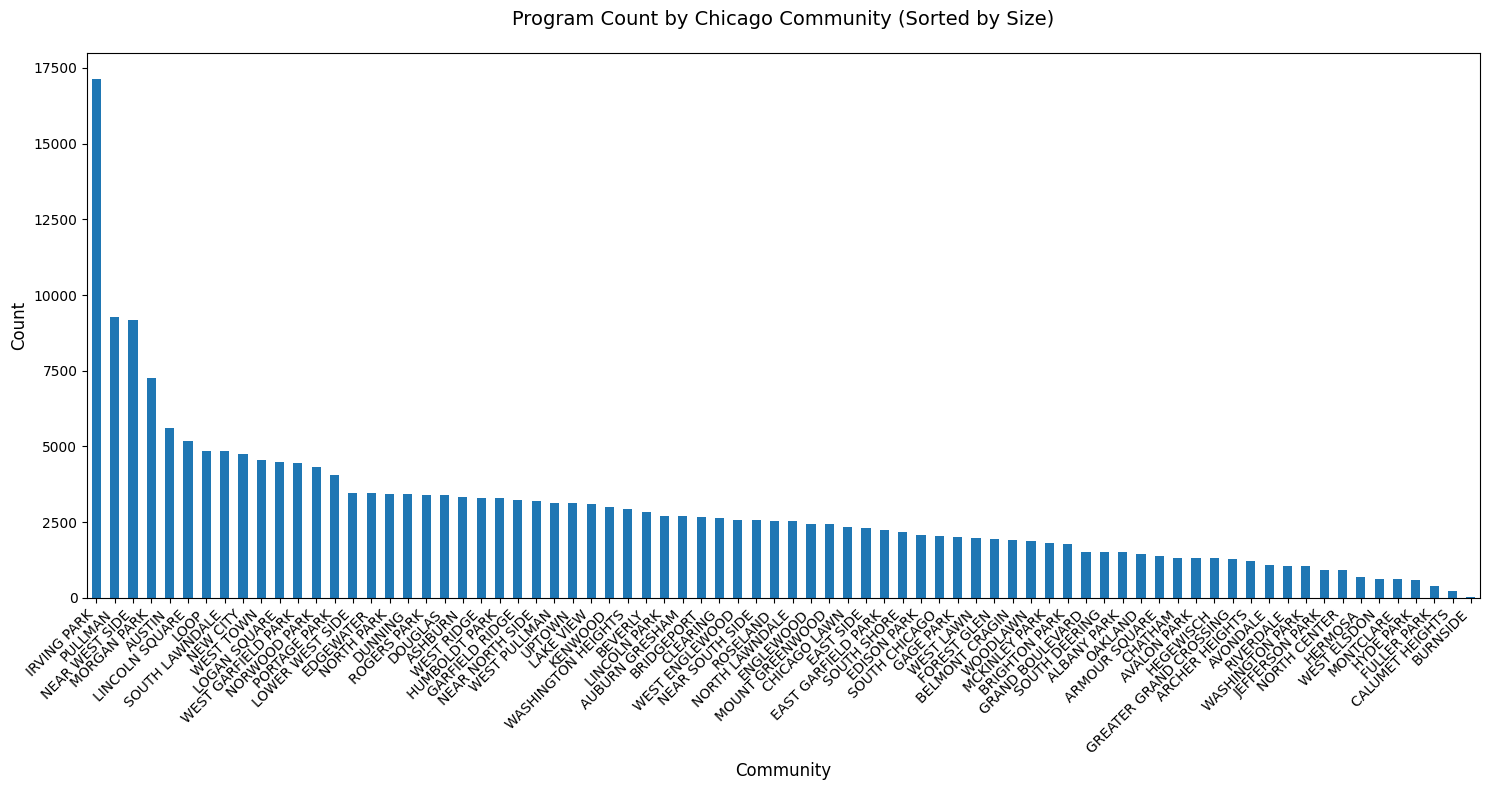

In [500]:
grouped_sizes = points_with_labels.groupby(['community']).size()
grouped_sizes_sorted = grouped_sizes.sort_values(ascending=False)

plt.figure(figsize=(15, 8))

bars = grouped_sizes_sorted.plot(kind='bar')

plt.title('Program Count by Chicago Community (Sorted by Size)', fontsize=14, pad=20)
plt.xlabel('Community', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(rotation=45, ha='right')



plt.tight_layout()
plt.show()


/var/folders/52/y8mfvm1n6vj12ntkl_p9hqw80000gn/T/ipykernel_72320/3883951718.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  crime_sum['centroid'] = crime_sum['geometry_polygon'].centroid


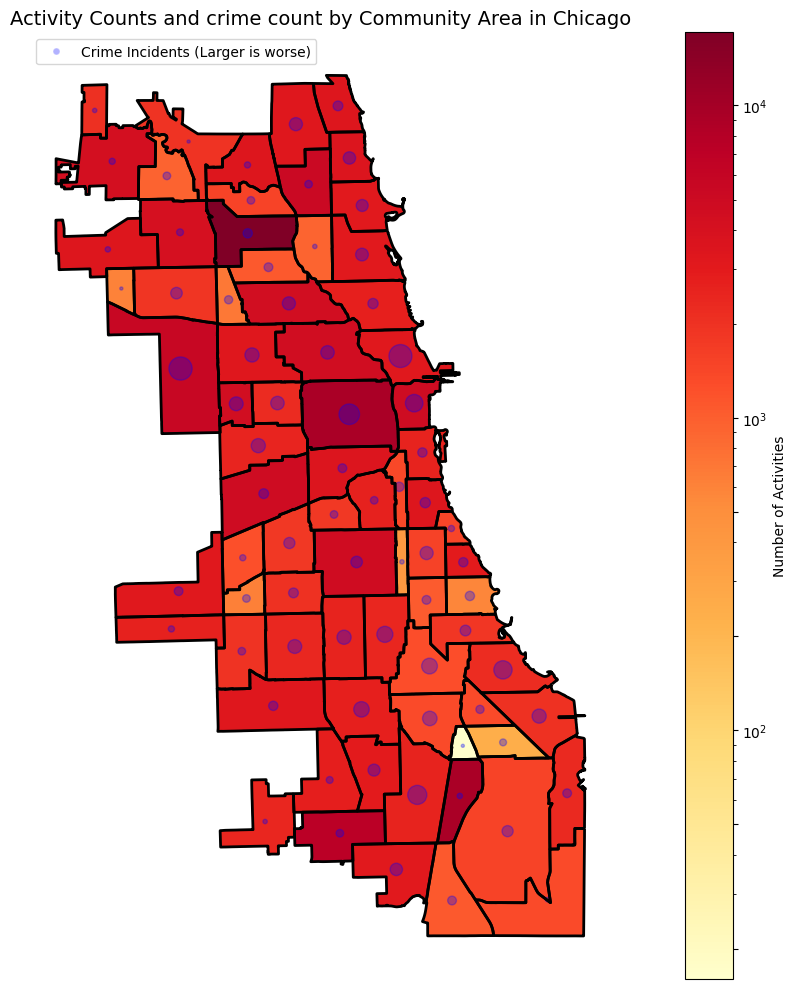

In [504]:
community_counts = points_with_labels.groupby('community').size().reset_index(name='count')
    
from shapely import wkt
community_gdf = community_counts.merge(points_with_labels, how='left', on='community').drop_duplicates(subset='community')[['community', 'count', 'geometry_polygon']]
community_gdf = gpd.GeoDataFrame(community_gdf, geometry='geometry_polygon')

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

from matplotlib.colors import LogNorm

# Plot the choropleth with logarithmic normalization
community_gdf.plot(
    column='count',
    ax=ax,
    legend=True,
    legend_kwds={
        'label': 'Number of Activities',
        'orientation': 'vertical',
        'ticks': [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 10000]  # Custom tick locations
    },
    missing_kwds={'color': 'lightgrey'},
    cmap='YlOrRd',
    norm=LogNorm()
)


geometry = [Point(xy) for xy in zip(crime['longitude'], crime['latitude'])]
crime_gdf_points = gpd.GeoDataFrame(crime, geometry=geometry)
crime_gdf_points.set_crs(epsg=4326, inplace=True)
crime_points_with_labels = gpd.sjoin(crime_gdf_points, shp_file, how='left', predicate='within')
crime_sum = crime_points_with_labels.groupby('community').size().reset_index(name='count')
crime_sum = crime_sum.merge(crime_points_with_labels, how='left', on='community').drop_duplicates(subset='community')[['community', 'count', 'geometry_polygon']]
crime_sum = gpd.GeoDataFrame(crime_sum, geometry='geometry_polygon', crs="EPSG:4326")
crime_sum['centroid'] = crime_sum['geometry_polygon'].centroid
crime_sum.set_geometry('centroid',inplace=True)
crime_sum.plot(
    ax=ax,
    color='blue',  
    alpha=0.3,     
    marker='.',   
    markersize=crime_sum['count'] * 20,   
)
shp_file.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='.', color='w', 
                         markerfacecolor='blue', markersize=10, alpha=0.3,
                         label='Crime Incidents (Larger is worse)')]
ax.legend(handles=legend_elements, loc='upper left')
plt.title('Activity Counts and crime count by Community Area in Chicago', fontsize=14)
ax.set_axis_off()
plt.tight_layout()


In [486]:
crime_sum = crime_points_with_labels.groupby('community').size().reset_index(name='count')
crime_sum = crime_sum.merge(crime_points_with_labels, how='left', on='community').drop_duplicates(subset='community')[['community', 'count', 'geometry_polygon']]
crime_sum = gpd.GeoDataFrame(crime_sum, geometry='geometry_polygon', crs="EPSG:4326")
crime_sum['centroid'] = crime_sum['geometry_polygon'].centroid


/var/folders/52/y8mfvm1n6vj12ntkl_p9hqw80000gn/T/ipykernel_72320/1012759367.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  crime_sum['centroid'] = crime_sum['geometry_polygon'].centroid


In [499]:
# correlation between crime and number of programs
crime_points_with_labels


,date,location,district,block,y_coordinate,latitude,description,location_description,updated_on,community_area,...,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry_polygon
0,2022-12-31 23:55:00,"{'latitude': '41.878373984', 'human_address': ...",015,055XX W ADAMS ST,1898786,41.878373984,RECKLESS FIREARM DISCHARGE,RESIDENCE - YARD (FRONT / BACK),2023-11-15 15:41:31,25,...,0.0,25,25,0.0,0.0,AUSTIN,0.0,1.992542e+08,75226.474917,"POLYGON ((-87.78942 41.91751, -87.78927 41.917..."
1,2022-12-31 23:50:00,"{'latitude': '42.009107852', 'human_address': ...",024,014XX W LUNT AVE,1946614,42.009107852,AUTOMOBILE,ALLEY,2023-01-07 15:41:08,1,...,0.0,1,1,0.0,0.0,ROGERS PARK,0.0,5.125990e+07,34052.397576,"POLYGON ((-87.65456 41.99817, -87.65574 41.998..."
2,2022-12-31 23:50:00,"{'latitude': '41.882256634', 'human_address': ...",015,055XX W WASHINGTON BLVD,1900199,41.882256634,DOMESTIC BATTERY SIMPLE,APARTMENT,2023-01-07 15:41:08,25,...,0.0,25,25,0.0,0.0,AUSTIN,0.0,1.992542e+08,75226.474917,"POLYGON ((-87.78942 41.91751, -87.78927 41.917..."
3,2022-12-31 23:47:00,"{'latitude': '41.72781203', 'human_address': '...",022,091XX S LAFLIN ST,1844124,41.72781203,SIMPLE,STREET,2023-01-07 15:41:08,73,...,0.0,73,73,0.0,0.0,WASHINGTON HEIGHTS,0.0,7.963575e+07,42222.598163,"POLYGON ((-87.63373 41.72885, -87.63369 41.726..."
4,2022-12-31 23:47:00,"{'latitude': '41.72781203', 'human_address': '...",022,091XX S LAFLIN ST,1844124,41.72781203,UNLAWFUL POSSESSION - HANDGUN,APARTMENT,2023-01-07 15:41:08,73,...,0.0,73,73,0.0,0.0,WASHINGTON HEIGHTS,0.0,7.963575e+07,42222.598163,"POLYGON ((-87.63373 41.72885, -87.63369 41.726..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-12-30 16:00:00,"{'latitude': '41.909664252', 'human_address': ...",025,046XX W NORTH AVE,1910225,41.909664252,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),2023-01-06 15:40:48,25,...,0.0,25,25,0.0,0.0,AUSTIN,0.0,1.992542e+08,75226.474917,"POLYGON ((-87.78942 41.91751, -87.78927 41.917..."
996,2022-12-30 16:00:00,"{'latitude': '41.855524939', 'human_address': ...",010,028XX W 19TH ST,1890584,41.855524939,SIMPLE,HOSPITAL BUILDING / GROUNDS,2023-01-06 15:40:48,30,...,0.0,30,30,0.0,0.0,SOUTH LAWNDALE,0.0,1.279983e+08,49904.045210,"POLYGON ((-87.6874 41.8348, -87.68796 41.83462..."
997,2022-12-30 16:00:00,"{'latitude': '41.675434364', 'human_address': ...",005,120XX S PRINCETON AVE,1825105,41.675434364,ATTEMPT - AUTOMOBILE,STREET,2023-01-06 15:40:48,53,...,0.0,53,53,0.0,0.0,WEST PULLMAN,0.0,9.936520e+07,50023.843001,"POLYGON ((-87.61828 41.65911, -87.61829 41.659..."
998,2022-12-30 16:00:00,"{'latitude': '41.86933231', 'human_address': '...",011,024XX W TAYLOR ST,1895637,41.86933231,ATTEMPT - AUTOMOBILE,STREET,2023-01-06 15:40:48,28,...,0.0,28,28,0.0,0.0,NEAR WEST SIDE,0.0,1.584925e+08,53003.592941,"POLYGON ((-87.63759 41.88623, -87.63765 41.886..."


In [502]:
# Difference of 4 orders of magnitude between the communities such as Burnside or Calumet Heights
points_with_labels.isna()

Index(['Program Name', 'Description', 'Org Name', 'Category Name', 'Capacity',
       'Min Age', 'Max Age', 'Address', 'City', 'ZIP Code', 'Program Type',
       'Start Date', 'End Date', 'Start Time', 'End Time', 'Program Price',
       'Geographic Cluster Name', 'Custom Categories', 'Tag', 'Latitude',
       'Longitude', 'Location', 'geometry', 'index_right', 'area',
       'area_num_1', 'area_numbe', 'comarea', 'comarea_id', 'community',
       'perimeter', 'shape_area', 'shape_len', 'geometry_polygon'],
      dtype='object')

In [ ]:
# correlation between number of programs and crime in each community? First principles
# heatmap

### Crime and number of programs...

### Merge datasets and derive additional variables